In [126]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(suppress=True)

import os

from models import DeepConditionalModel
from inn_utils import train_loop_dataset
from process_models import simulate_ricker
from viz import plot_true_est_scatter, plot_true_est_posterior

In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Summary network for the seqRNA model
<p>We use a residual network for the observed count data.</p>

In [4]:
class ResidualNetwork(tf.keras.Model):
    
    def __init__(self):
        super(ResidualNetwork, self).__init__()
        
        # Initial simple 1D convolution 
        self.conv_part = tf.keras.Sequential([
            tf.keras.layers.Conv1D(64, kernel_size=1, strides=1, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ELU(),
        ])
        
        # Sequence of residual blocks
        self.residual_part = tf.keras.Sequential([
            ResidualBlock(64),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        ])
        
        # Global average pooling
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        
        # Sequence of FC layers
        self.dense_part = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer='glorot_uniform')
        ])
        
        
    def call(self, x, training=True):
        
        x = self.conv_part(x, training=training)
        x = self.residual_part(x, training=training)
        summary = self.dense_part(self.avg_pool(x))
        return summary
    
class ResidualBlock(tf.keras.Model):
    
    def __init__(self, n_out, kernel_size=2, strides=2):
        super(ResidualBlock, self).__init__()
        
        self.conv_part = tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_out, kernel_size=kernel_size, strides=strides, use_bias=False,
                                   kernel_initializer='glorot_uniform', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ELU(),
            tf.keras.layers.Conv1D(n_out, kernel_size=kernel_size, strides=1, use_bias=False,
                                   kernel_initializer='glorot_uniform', padding='same'),
            tf.keras.layers.BatchNormalization()
        ])
        
        self.downsample = tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_out, kernel_size=1, strides=strides, use_bias=False, 
                                   kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization()
        ])
        
        
    def call(self, x):
        
        identity = x
        out = self.conv_part(x)
        identity = self.downsample(identity)
        out = tf.nn.elu(out + identity)
        return out

# Data loader for seqRNA matrices

In [128]:
class RNADataLoader:
    """A class to sequentially load batches of seq RNA matrices."""
    def __init__(self, batch_size=32, data_path='.', normalize=True, 
                 shuffle= True, n_cells=100, n_genes=100, n_sim_chunk=5000):
        
        self.data_path = data_path
        self._batch_size = batch_size
        self._n_cells = n_cells
        self._n_genes = n_genes
        self._n_sim = n_sim_chunk
        self._idx = 0
        self._normalize = normalize
        self._shuffle = shuffle
        self._num_chunks = self._get_num_chunks()
        self._data_files_list = self._get_data_files()
        self._param_files_list = self._get_param_files()
        assert len(self._data_files_list) == len(self._param_files_list), '# Data files in {} must equal # params files'.format(self.path)
        
        self._global_max = 0
        # This takes time
        if self._normalize:
            self._get_global_max()        
        if self._shuffle:
            self._shuffle_chunks()

    
    def _shuffle_chunks(self):
        """Shuffles the order of the chunks."""

        self._data_files_list, self._param_files_list = shuffle(self._data_files_list, self._param_files_list)
    
    def _get_num_chunks(self):
        
        return len(os.listdir(os.path.join(self.data_path, 'data'))) 
    
    def _get_data_files(self):
        
        return [os.path.join(self.data_path, 'data', f) 
                for f in os.listdir(os.path.join(self.data_path, 'data'))]
    
    def _get_param_files(self):
        
        return [os.path.join(self.data_path, 'params', f) 
                for f in os.listdir(os.path.join(self.data_path, 'params'))]
    
    def _get_global_max(self):
        """Determines the global maximum count over all counts dataset."""
        
        self._global_max = 0
        for data_file in self._data_files_list:
            X = np.load(data_file).astype(np.float32)
            max_count = np.max(X)
            if max_count > self._global_max:
                self._global_max = max_count
        print('Global max determined: ', self._global_max)
            
    
    def load_test(self, n_test, path='.', to_tensor=True):
        """Loads a test dataset."""
        
        X = np.load(os.path.join(path, 'test', 'rna_data_test.npy')).astype(np.float32)
        y = np.load(os.path.join(path, 'test', 'rna_params_test.npy')).astype(np.float32)
        X = X.reshape(self._n_genes, self._n_cells, n_test).T
        if to_tensor:
            X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        return X, y
    
    def _load_next(self):
        """Loads the current data files."""
        
        # Make sure a corresponding pair of data-params is loaded
        data_file = self._data_files_list[self._idx]
        params_file = self._param_files_list[self._idx]
        assert data_file.split('_')[-1] == params_file.split('_')[-1]
        
        # Load as numpy
        X = np.load(data_file).astype(np.float32)
        y = np.load(params_file).astype(np.float32)
        
        # Convert to N_sim x Genes x Cells tensor
        X = X.reshape(self._n_genes, self._n_cells, self._n_sim).T
        
        # Normalize
        if self._normalize:
            X /= self._global_max
        
        # Create a tf dataset
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0]).batch(self._batch_size)

        # Increment index and return dataset
        self._idx = self._idx + 1
        return dataset
    
    def __iter__(self): 
        return self
    
    def __next__(self):
        # Increment index and check if we are at the end of the file list 
        if self._idx == self._num_chunks:
            self._idx = 0
            if self._shuffle:
                self._shuffle_chunks()
            raise StopIteration
        return self._load_next()

In [107]:
def remove_implausible(X_batch, theta_batch, zeros_tolerated=1000):
    """Removes implausible simulated matrices from batch."""
    
    plausible = tf.reduce_sum(tf.cast(tf.equal(X_batch, 0.), tf.int32), axis=(1, 2)) < zeros_tolerated
    X_batch_plausible = tf.boolean_mask(X_batch, plausible, axis=0)
    theta_batch_plausible = tf.boolean_mask(theta_batch, plausible, axis=0)
    return X_batch_plausible, theta_batch_plausible

# Initialization 

In [142]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [128, 128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
n_chunks = 50
n_sim_chunk = 5000
param_names = ['alpha', 'beta', 'out_loc', 'out_scale', 
               'lib_loc', 'lib_scale', 'out_prob', 'bcv']
theta_dim = 8
#global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
epochs = 10
n_inv_blocks = 10
data_path = 'D:\\seqRNA'
n_samples_posterior = 1000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 5000
decay_rate = .9
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [129]:
data_loader  = RNADataLoader(batch_size, data_path, normalize=True)

## Create a test set

In [134]:
X_test, theta_test = data_loader.load_test(n_test=500, path=data_path)

In [156]:
X_test_plausible, theta_test_plausible = remove_implausible(X_test, theta_test, 1000)

In [158]:
summary_net = ResidualNetwork()
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Plot performance of untrained model

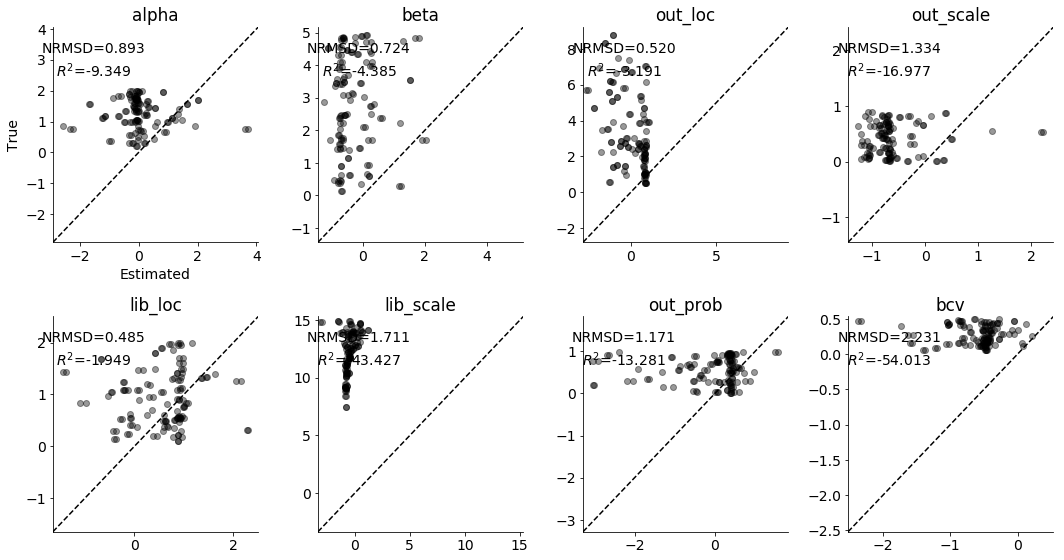

In [159]:
plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, n_samples_posterior, param_names, figsize=(15, 8))

# Train the model

In [113]:
for ep in range(1, epochs+1):
    with tqdm(total=n_chunks * n_sim_chunk // batch_size, desc='Epoch {}'.format(ep)) as p_bar:
        for chunk in data_loader:
            losses = train_loop_dataset(model, optimizer, chunk, batch_size, p_bar, 
                                        clip_value=clip_value, global_step=global_step, transform=remove_implausible)
            plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, 
                                  n_samples_posterior, param_names, figsize=(15, 8))

KeyboardInterrupt: 

In [21]:
model

In [23]:
model.save_weights('models/seqrna_test')

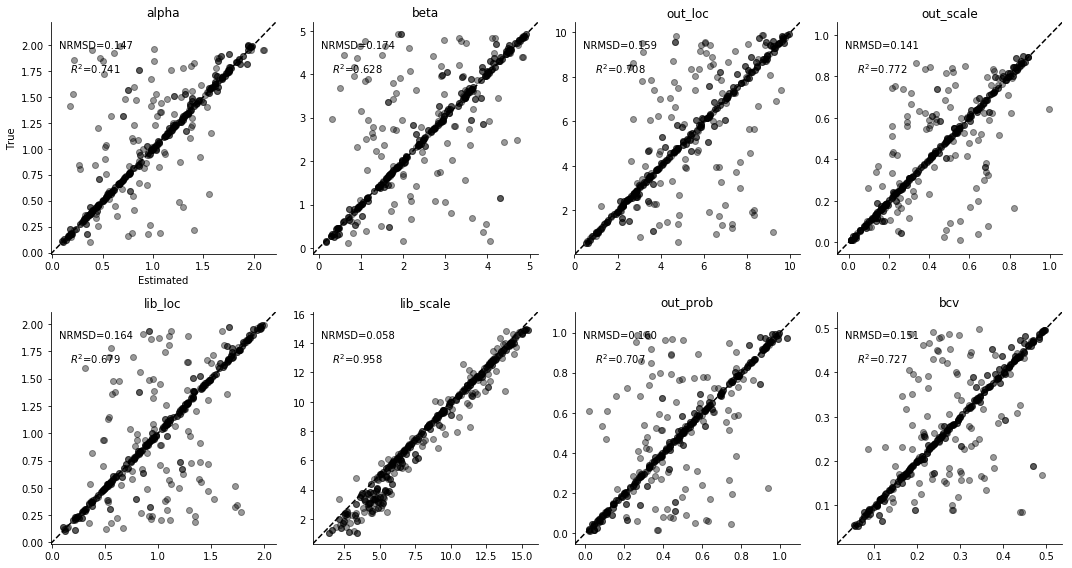

In [66]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(15, 8))

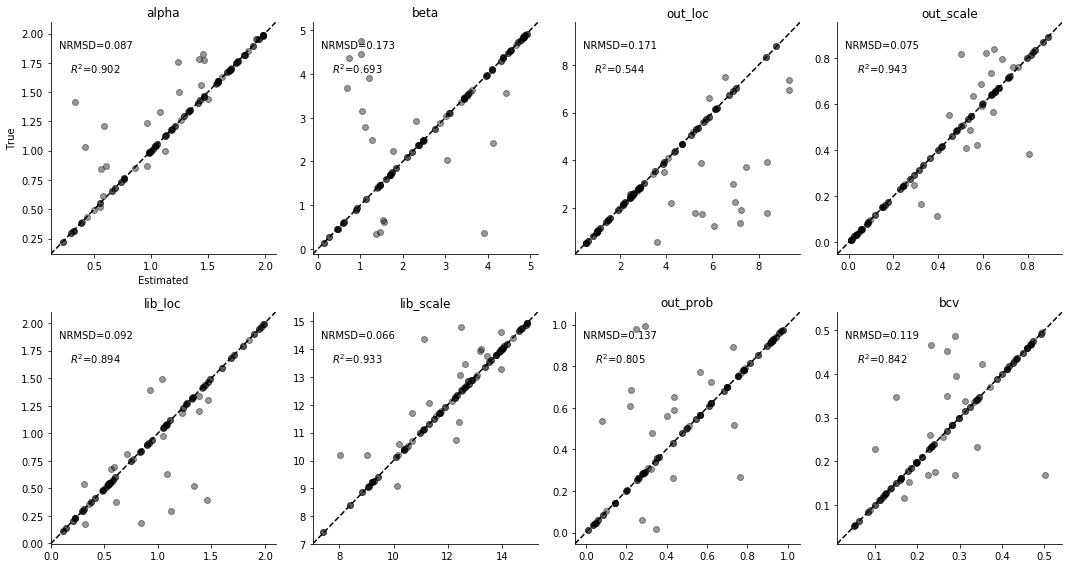

In [86]:
plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, 
                      n_samples_posterior, param_names, figsize=(15, 8))

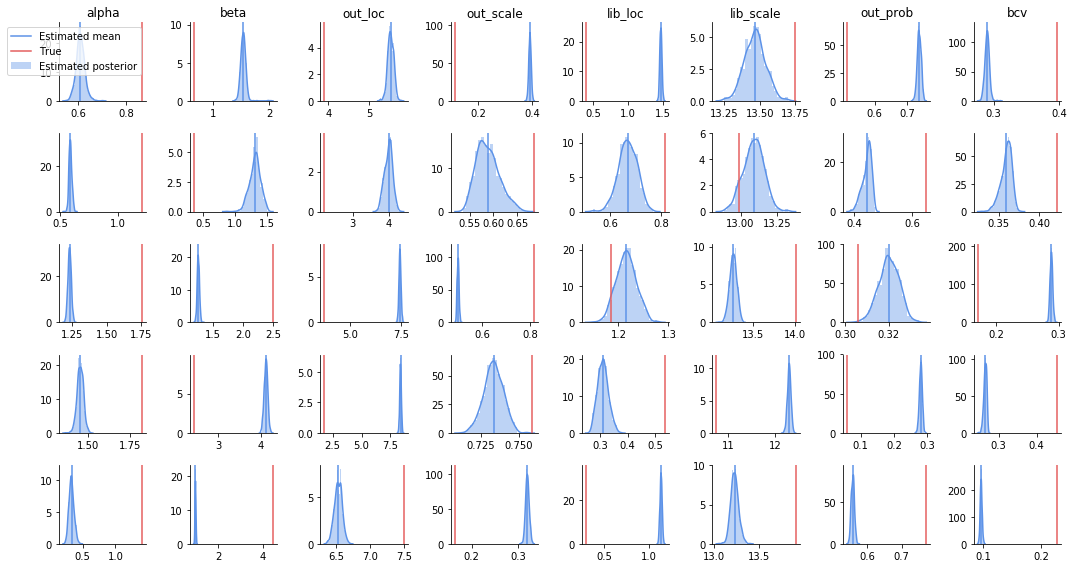

In [82]:
plot_true_est_posterior(model, n_samples=1000, param_names=param_names, 
                        X_test=X_test_plausible[:5], theta_test=theta_test_plausible[:5], figsize=(15, 8))